In [1]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid using all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU:", gpus)
    except RuntimeError as e:
        print("Error:", e)
else:
    print("No GPU detected. Running on CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


##  Import the Required Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


## Load and Preprocess the Dataset

In [3]:
# Define the base directory
base_dir = "/kaggle/input/leapgestrecog/leapGestRecog"

# Initialize an empty list to store the data
data = []

# Traverse the directory structure
for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    if os.path.isdir(sub_dir_path):  # Ensure it's a directory
        for label in os.listdir(sub_dir_path):
            label_path = os.path.join(sub_dir_path, label)
            if os.path.isdir(label_path):  # Ensure it's a label directory
                for image_file in os.listdir(label_path):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                        image_path = os.path.join(label_path, image_file)
                        data.append({'image_path': image_path, 'label': label})

# Create a DataFrame
df = pd.DataFrame(data)


In [4]:
# Split the data into training, testing, and validation sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42, shuffle=True)


In [5]:

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 14000
Validation samples: 3000
Testing samples: 3000


In [6]:
# --- Image Preprocessing ---
def process_images(file_paths, target_size=(224, 224)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)  # Resize images
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

X_train = process_images(train_df['image_path'])
X_val = process_images(val_df['image_path'])
X_test = process_images(test_df['image_path'])


In [7]:
# --- Encode Labels ---
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

Y_train_int = label_encoder.fit_transform(train_df['label'])
Y_train = one_hot_encoder.fit_transform(Y_train_int.reshape(-1, 1))

Y_val_int = label_encoder.transform(val_df['label'])
Y_val = one_hot_encoder.transform(Y_val_int.reshape(-1, 1))

Y_test_int = label_encoder.transform(test_df['label'])
Y_test = one_hot_encoder.transform(Y_test_int.reshape(-1, 1))

# --- Augmentation ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Define the DenseNet Model

In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Additional dropout
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Output layer


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Create the model



In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
# --- Train the Model ---
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=20,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734531459.829000      67 service.cc:145] XLA service 0x7d5ce40026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734531459.829062      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734531459.829067      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/438 ━━━━━━━━━━━━━━━━━━━━ 4:05:11 34s/step - accuracy: 0.1562 - loss: 3.5392

I0000 00:00:1734531477.952151      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 221s 429ms/step - accuracy: 0.1714 - loss: 2.5687 - val_accuracy: 0.8133 - val_loss: 1.3384
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 150s 338ms/step - accuracy: 0.4385 - loss: 1.6255 - val_accuracy: 0.9263 - val_loss: 0.6138
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 332ms/step - accuracy: 0.5885 - loss: 1.1825 - val_accuracy: 0.9443 - val_loss: 0.3566
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 158s 354ms/step - accuracy: 0.6831 - loss: 0.9255 - val_accuracy: 0.9717 - val_loss: 0.2436
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 153s 344ms/step - accuracy: 0.7368 - loss: 0.7669 - val_accuracy: 0.9740 - val_loss: 0.1911
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 333ms/step - accuracy: 0.7700 - loss: 0.6728 - val_accuracy: 0.9690 - val_loss: 0.1602
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 151s 339ms/step - accuracy: 0.7952 - loss: 0.6111 - val_accuracy: 0.9770 - val_loss: 0.1312
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 146s 328ms/step - accuracy: 0.8044 - loss: 0.56

##  Evaluate the Model 

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9933 - loss: 0.0522
Test Loss: 0.051536157727241516, Test Accuracy: 0.9936666488647461


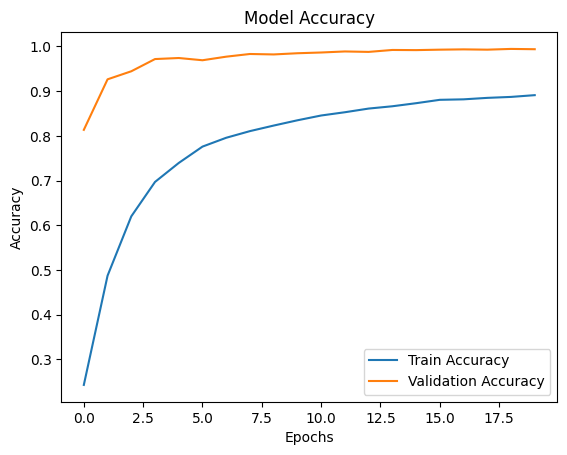

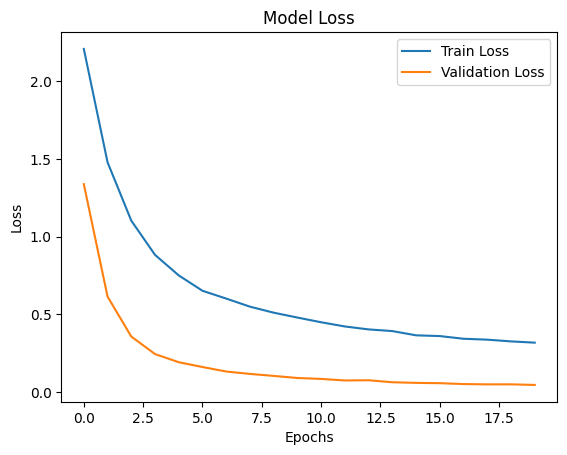

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step
               precision    recall  f1-score   support

      01_palm       0.99      1.00      1.00       300
         02_l       1.00      0.99      0.99       300
      03_fist       0.99      0.99      0.99       300
04_fist_moved       0.99      0.98      0.99       300
     05_thumb       0.99      0.99      0.99       300
     06_index       0.99      1.00      1.00       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      0.99      1.00       300
         09_c       0.98      1.00      0.99       300
      10_down       1.00      1.00      1.00       300

     accuracy                           0.99      3000
    macro avg       0.99      0.99      0.99      3000
 weighted avg       0.99      0.99      0.99      3000



In [11]:

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# --- Visualize Results ---
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Generate Classification Report ---
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


plt.show()


In [12]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import seaborn as sns


Test Accuracy: 99.37%
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step


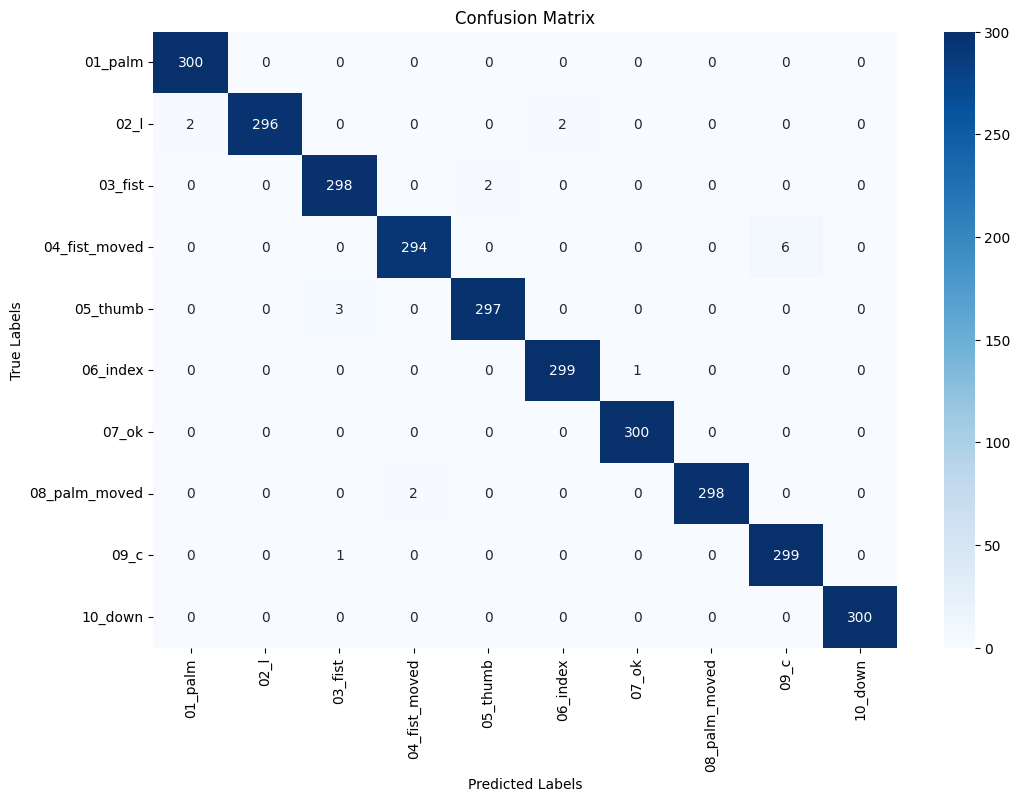

               precision    recall  f1-score   support

      01_palm       0.99      1.00      1.00       300
         02_l       1.00      0.99      0.99       300
      03_fist       0.99      0.99      0.99       300
04_fist_moved       0.99      0.98      0.99       300
     05_thumb       0.99      0.99      0.99       300
     06_index       0.99      1.00      1.00       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      0.99      1.00       300
         09_c       0.98      1.00      0.99       300
      10_down       1.00      1.00      1.00       300

     accuracy                           0.99      3000
    macro avg       0.99      0.99      0.99      3000
 weighted avg       0.99      0.99      0.99      3000

ROC-AUC Score: 1.00


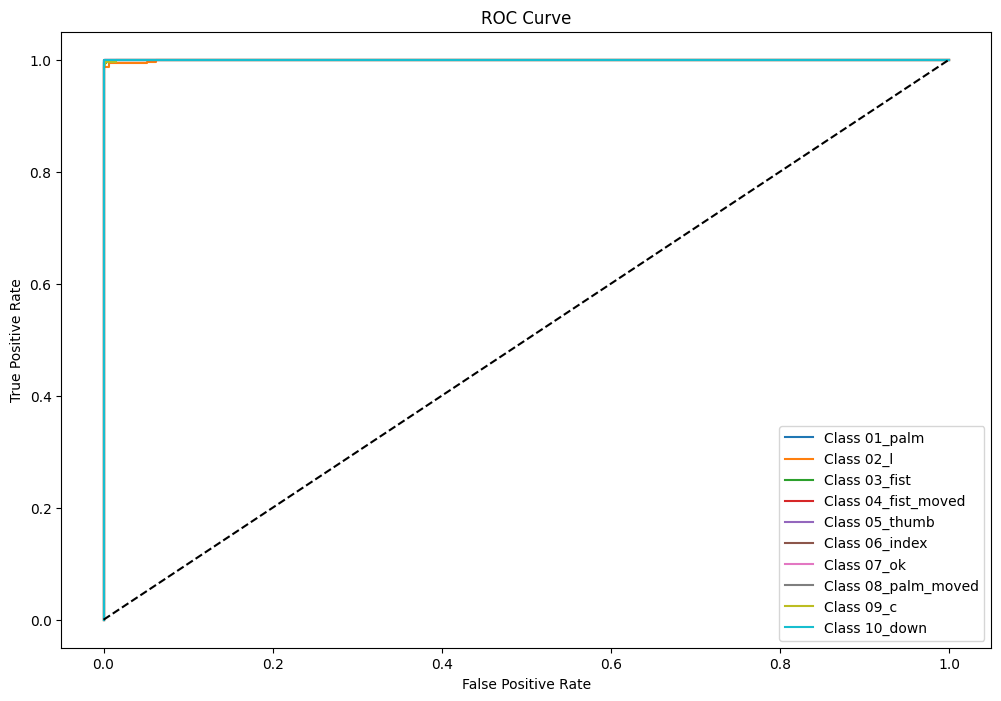

In [13]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(Y_true_classes, Y_pred_classes, target_names=label_encoder.classes_))

# ROC-AUC Curve
roc_auc = roc_auc_score(Y_test, Y_pred, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr = {}
tpr = {}
thresholds = {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y_test[:, i], Y_pred[:, i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()